In [ ]:
#Librerias usadas en la prueba
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
from matplotlib import pyplot
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
#Cargar dataset de consumo energético diario
energy=pd.read_csv('gdrive/My Drive/Colab Notebooks/Proyecto/daily_dataset/energy.csv')
#energy = pd.read_csv('energy.csv')
len(energy)

3536007

In [22]:
energy.head()

,Unnamed: 0,day,LCLid,energy_sum
0,0,2012-10-12,MAC000002,7.098
1,1,2012-10-13,MAC000002,11.087
2,2,2012-10-14,MAC000002,13.223
3,3,2012-10-15,MAC000002,10.257
4,4,2012-10-16,MAC000002,9.769


In [0]:
energy1=energy[['day','LCLid', 'energy_sum']]

In [24]:
energy1.head()

,day,LCLid,energy_sum
0,2012-10-12,MAC000002,7.098
1,2012-10-13,MAC000002,11.087
2,2012-10-14,MAC000002,13.223
3,2012-10-15,MAC000002,10.257
4,2012-10-16,MAC000002,9.769


In [0]:
#Cargar dataset con la información de Acorn(Clasificación Socioeconómica) de cada una de las casas
households=pd.read_csv('gdrive/My Drive/Colab Notebooks/Proyecto/daily_dataset/informations_households.csv')

In [26]:
households.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [27]:
households.loc[households.Acorn == 'ACORN-D'].head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
335,MAC004539,Std,ACORN-D,Affluent,block_6
336,MAC000336,ToU,ACORN-D,Affluent,block_6
337,MAC000342,ToU,ACORN-D,Affluent,block_6
338,MAC001698,Std,ACORN-D,Affluent,block_6
339,MAC000727,Std,ACORN-D,Affluent,block_6


In [28]:
#Tabla de Frecuencia de los Grupos de Acorn
pd.value_counts(households['Acorn_grouped'])

Affluent       2192
Adversity      1816
Comfortable    1507
ACORN-U          49
ACORN-            2
Name: Acorn_grouped, dtype: int64

In [0]:
household1=households[['LCLid', 'Acorn', 'Acorn_grouped']]

In [30]:
household1.head()

,LCLid,Acorn,Acorn_grouped
0,MAC005492,ACORN-,ACORN-
1,MAC001074,ACORN-,ACORN-
2,MAC000002,ACORN-A,Affluent
3,MAC003613,ACORN-A,Affluent
4,MAC003597,ACORN-A,Affluent


In [0]:
#Se unen las tablas energy1 y household1
allblockhousehold=pd.merge(energy1, household1, how ='left', on ='LCLid') 

In [32]:
allblockhousehold.head()

,day,LCLid,energy_sum,Acorn,Acorn_grouped
0,2012-10-12,MAC000002,7.098,ACORN-A,Affluent
1,2012-10-13,MAC000002,11.087,ACORN-A,Affluent
2,2012-10-14,MAC000002,13.223,ACORN-A,Affluent
3,2012-10-15,MAC000002,10.257,ACORN-A,Affluent
4,2012-10-16,MAC000002,9.769,ACORN-A,Affluent


In [33]:
allblockhousehold.tail()

,day,LCLid,energy_sum,Acorn,Acorn_grouped
3536002,2014-02-24,MAC004828,2.587,ACORN-U,ACORN-U
3536003,2014-02-25,MAC004828,0.720,ACORN-U,ACORN-U
3536004,2014-02-26,MAC004828,1.051,ACORN-U,ACORN-U
3536005,2014-02-27,MAC004828,0.736,ACORN-U,ACORN-U
3536006,2014-02-28,MAC004828,0.000,ACORN-U,ACORN-U


In [34]:
len(allblockhousehold)

3536007

In [0]:
allblockhousehold['day']=pd.to_datetime(allblockhousehold['day'])

In [36]:
allblockhousehold.head()

,day,LCLid,energy_sum,Acorn,Acorn_grouped
0,2012-10-12,MAC000002,7.098,ACORN-A,Affluent
1,2012-10-13,MAC000002,11.087,ACORN-A,Affluent
2,2012-10-14,MAC000002,13.223,ACORN-A,Affluent
3,2012-10-15,MAC000002,10.257,ACORN-A,Affluent
4,2012-10-16,MAC000002,9.769,ACORN-A,Affluent


In [0]:
#Se realiza una agrupacion por Acorn_Group para separar Afluentes, Confortables y Adversity
acorn=allblockhousehold.groupby('Acorn_grouped')

In [0]:
#Buscar 100 Casas que sean caracterizadas como Comfortable y obtener el consumo energético agregado
confortable=acorn.get_group('Comfortable')

In [39]:
confortable.head()

,day,LCLid,energy_sum,Acorn,Acorn_grouped
1414652,2012-05-03,MAC001028,10.129,ACORN-F,Comfortable
1414653,2012-05-04,MAC001028,11.307,ACORN-F,Comfortable
1414654,2012-05-05,MAC001028,10.093,ACORN-F,Comfortable
1414655,2012-05-06,MAC001028,12.314,ACORN-F,Comfortable
1414656,2012-05-07,MAC001028,10.669,ACORN-F,Comfortable


In [40]:
len(confortable['LCLid'].unique())

1507

In [41]:
len(confortable)

937069

In [0]:
confortable.set_index('day', inplace=True)

In [43]:
confortable.head()

,LCLid,energy_sum,Acorn,Acorn_grouped
day,,,,
2012-05-03,MAC001028,10.129,ACORN-F,Comfortable
2012-05-04,MAC001028,11.307,ACORN-F,Comfortable
2012-05-05,MAC001028,10.093,ACORN-F,Comfortable
2012-05-06,MAC001028,12.314,ACORN-F,Comfortable
2012-05-07,MAC001028,10.669,ACORN-F,Comfortable


In [0]:
confortable2=confortable["2013-01-01":"2013-12-31"]

In [0]:
confortable2=confortable["2012-01-01"]

In [46]:
confortable2.head()

,LCLid,energy_sum,Acorn,Acorn_grouped
day,,,,
2012-01-01,MAC000125,3.251,ACORN-F,Comfortable
2012-01-01,MAC000243,17.796,ACORN-F,Comfortable
2012-01-01,MAC000244,7.163,ACORN-F,Comfortable
2012-01-01,MAC000248,25.205,ACORN-F,Comfortable
2012-01-01,MAC000262,20.716,ACORN-F,Comfortable


In [47]:
len(confortable2)

114

In [0]:
c=list(confortable2['LCLid'].unique())

In [49]:
#Se filtran las casas de Acorn Confortable que tienen más datos
confortableok = confortable[confortable.LCLid.isin(c)]
confortableok.head()

,LCLid,energy_sum,Acorn,Acorn_grouped
day,,,,
2011-12-15,MAC000125,9.591,ACORN-F,Comfortable
2011-12-16,MAC000125,13.889,ACORN-F,Comfortable
2011-12-17,MAC000125,24.136,ACORN-F,Comfortable
2011-12-18,MAC000125,15.833,ACORN-F,Comfortable
2011-12-19,MAC000125,12.508,ACORN-F,Comfortable


In [50]:
len(confortableok['LCLid'].unique())

114

In [0]:
#Se hace un reshape de la tabla con los confortables
table_confortableok = pd.pivot_table(confortableok, index=['day'], values='energy_sum',  columns=['LCLid'])

In [52]:
table_confortableok.head()

LCLid,MAC000020,MAC000027,MAC000039,MAC000043,MAC000044,MAC000051,MAC000053,MAC000059,MAC000060,MAC000062,MAC000069,MAC000070,MAC000071,MAC000074,MAC000083,MAC000089,MAC000091,MAC000093,MAC000094,MAC000097,MAC000098,MAC000108,MAC000118,MAC000124,MAC000125,MAC000128,MAC000137,MAC000143,MAC000145,MAC000147,MAC000148,MAC000149,MAC000151,MAC000156,MAC000157,MAC000158,MAC000160,MAC000163,MAC000167,MAC000170,...,MAC000254,MAC000259,MAC000260,MAC000261,MAC000262,MAC000265,MAC000271,MAC000272,MAC004456,MAC004457,MAC004460,MAC004466,MAC004472,MAC004478,MAC004483,MAC004484,MAC004485,MAC004488,MAC004491,MAC004492,MAC004494,MAC004499,MAC004501,MAC004502,MAC004506,MAC004521,MAC004523,MAC004526,MAC004542,MAC004545,MAC004551,MAC004557,MAC004572,MAC004578,MAC004580,MAC004845,MAC004850,MAC004859,MAC004862,MAC004867
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.952,3.036,1.283,2.287,3.273,6.523,7.408,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.135,7.489,2.304,4.331,4.620,12.689,14.258,3.181,3.957,7.758,1.138,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.720,6.185,2.324,4.373,4.783,10.717,14.818,3.467,9.982,11.359,0.582,12.876,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.234,6.964,2.295,4.335,4.935,12.442,11.265,2.815,11.524,19.174,0.537,15.002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.189,7.912,2.302,4.375,4.553,12.964,12.328,3.638,11.897,22.100,1.375,12.800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#Quita todas las filas donde hay valores nulos
table_confortableok2=table_confortableok.dropna(axis='columns', how="all")

In [54]:
table_confortableok2.head()

LCLid,MAC000020,MAC000027,MAC000039,MAC000043,MAC000044,MAC000051,MAC000053,MAC000059,MAC000060,MAC000062,MAC000069,MAC000070,MAC000071,MAC000074,MAC000083,MAC000089,MAC000091,MAC000093,MAC000094,MAC000097,MAC000098,MAC000108,MAC000118,MAC000124,MAC000125,MAC000128,MAC000137,MAC000143,MAC000145,MAC000147,MAC000148,MAC000149,MAC000151,MAC000156,MAC000157,MAC000158,MAC000160,MAC000163,MAC000167,MAC000170,...,MAC000254,MAC000259,MAC000260,MAC000261,MAC000262,MAC000265,MAC000271,MAC000272,MAC004456,MAC004457,MAC004460,MAC004466,MAC004472,MAC004478,MAC004483,MAC004484,MAC004485,MAC004488,MAC004491,MAC004492,MAC004494,MAC004499,MAC004501,MAC004502,MAC004506,MAC004521,MAC004523,MAC004526,MAC004542,MAC004545,MAC004551,MAC004557,MAC004572,MAC004578,MAC004580,MAC004845,MAC004850,MAC004859,MAC004862,MAC004867
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.952,3.036,1.283,2.287,3.273,6.523,7.408,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.135,7.489,2.304,4.331,4.620,12.689,14.258,3.181,3.957,7.758,1.138,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.720,6.185,2.324,4.373,4.783,10.717,14.818,3.467,9.982,11.359,0.582,12.876,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.234,6.964,2.295,4.335,4.935,12.442,11.265,2.815,11.524,19.174,0.537,15.002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.189,7.912,2.302,4.375,4.553,12.964,12.328,3.638,11.897,22.100,1.375,12.800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#Se realiza una interpolacion del dataset para llenar los valores con NAN usando el metodo time donde se tiene en cuenta la
#relación temporal para la asignación de valores
confortable_interpolate=table_confortableok2.interpolate(method="time", limit_direction='both')

In [56]:
confortable_interpolate.head()

LCLid,MAC000020,MAC000027,MAC000039,MAC000043,MAC000044,MAC000051,MAC000053,MAC000059,MAC000060,MAC000062,MAC000069,MAC000070,MAC000071,MAC000074,MAC000083,MAC000089,MAC000091,MAC000093,MAC000094,MAC000097,MAC000098,MAC000108,MAC000118,MAC000124,MAC000125,MAC000128,MAC000137,MAC000143,MAC000145,MAC000147,MAC000148,MAC000149,MAC000151,MAC000156,MAC000157,MAC000158,MAC000160,MAC000163,MAC000167,MAC000170,...,MAC000254,MAC000259,MAC000260,MAC000261,MAC000262,MAC000265,MAC000271,MAC000272,MAC004456,MAC004457,MAC004460,MAC004466,MAC004472,MAC004478,MAC004483,MAC004484,MAC004485,MAC004488,MAC004491,MAC004492,MAC004494,MAC004499,MAC004501,MAC004502,MAC004506,MAC004521,MAC004523,MAC004526,MAC004542,MAC004545,MAC004551,MAC004557,MAC004572,MAC004578,MAC004580,MAC004845,MAC004850,MAC004859,MAC004862,MAC004867
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-11-23,6.153,3.997,10.188,2.197,5.379,3.801,9.534,12.781,10.6,7.568,5.611,5.582,14.128,12.625,17.585,9.391,4.723,3.932,4.877,8.497,8.611,3.053,6.931,8.499,9.591,3.495,7.371,8.864,8.952,3.036,1.283,2.287,3.273,6.523,7.408,3.181,3.957,7.758,1.138,12.876,...,20.645,9.359,5.537,4.984,10.001,7.428,6.863,11.419,23.696,3.971,9.98,28.143,16.467,13.989,10.956,22.25,5.967,7.929,8.037,5.347,10.073,8.531,12.213,11.061,4.297,7.073,5.691,4.188,1.266,2.211,2.904,8.615,11.828,5.845,3.791,3.554,3.454,11.202,4.766,2.517
2011-11-24,6.153,3.997,10.188,2.197,5.379,3.801,9.534,12.781,10.6,7.568,5.611,5.582,14.128,12.625,17.585,9.391,4.723,3.932,4.877,8.497,8.611,3.053,6.931,8.499,9.591,3.495,7.371,8.864,12.135,7.489,2.304,4.331,4.620,12.689,14.258,3.181,3.957,7.758,1.138,12.876,...,20.645,9.359,5.537,4.984,10.001,7.428,6.863,11.419,23.696,3.971,9.98,28.143,16.467,13.989,10.956,22.25,5.967,7.929,8.037,5.347,10.073,8.531,12.213,11.061,4.297,7.073,5.691,4.188,1.266,2.211,2.904,8.615,11.828,5.845,3.791,3.554,3.454,11.202,4.766,2.517
2011-11-25,6.153,3.997,10.188,2.197,5.379,3.801,9.534,12.781,10.6,7.568,5.611,5.582,14.128,12.625,17.585,9.391,4.723,3.932,4.877,8.497,8.611,3.053,6.931,8.499,9.591,3.495,7.371,8.864,13.720,6.185,2.324,4.373,4.783,10.717,14.818,3.467,9.982,11.359,0.582,12.876,...,20.645,9.359,5.537,4.984,10.001,7.428,6.863,11.419,23.696,3.971,9.98,28.143,16.467,13.989,10.956,22.25,5.967,7.929,8.037,5.347,10.073,8.531,12.213,11.061,4.297,7.073,5.691,4.188,1.266,2.211,2.904,8.615,11.828,5.845,3.791,3.554,3.454,11.202,4.766,2.517
2011-11-26,6.153,3.997,10.188,2.197,5.379,3.801,9.534,12.781,10.6,7.568,5.611,5.582,14.128,12.625,17.585,9.391,4.723,3.932,4.877,8.497,8.611,3.053,6.931,8.499,9.591,3.495,7.371,8.864,15.234,6.964,2.295,4.335,4.935,12.442,11.265,2.815,11.524,19.174,0.537,15.002,...,20.645,9.359,5.537,4.984,10.001,7.428,6.863,11.419,23.696,3.971,9.98,28.143,16.467,13.989,10.956,22.25,5.967,7.929,8.037,5.347,10.073,8.531,12.213,11.061,4.297,7.073,5.691,4.188,1.266,2.211,2.904,8.615,11.828,5.845,3.791,3.554,3.454,11.202,4.766,2.517
2011-11-27,6.153,3.997,10.188,2.197,5.379,3.801,9.534,12.781,10.6,7.568,5.611,5.582,14.128,12.625,17.585,9.391,4.723,3.932,4.877,8.497,8.611,3.053,6.931,8.499,9.591,3.495,7.371,8.864,13.189,7.912,2.302,4.375,4.553,12.964,12.328,3.638,11.897,22.100,1.375,12.800,...,20.645,9.359,5.537,4.984,10.001,7.428,6.863,11.419,23.696,3.971,9.98,28.143,16.467,13.989,10.956,22.25,5.967,7.929,8.037,5.347,10.073,8.531,12.213,11.061,4.297,7.073,5.691,4.188,1.266,2.211,2.904,8.615,11.828,5.845,3.791,3.554,3.454,11.202,4.766,2.517


In [0]:
#Se seleccionan las 100 primeras casas
df2 = confortable_interpolate.iloc[:,0:100]

In [58]:
df2.head()

LCLid,MAC000020,MAC000027,MAC000039,MAC000043,MAC000044,MAC000051,MAC000053,MAC000059,MAC000060,MAC000062,MAC000069,MAC000070,MAC000071,MAC000074,MAC000083,MAC000089,MAC000091,MAC000093,MAC000094,MAC000097,MAC000098,MAC000108,MAC000118,MAC000124,MAC000125,MAC000128,MAC000137,MAC000143,MAC000145,MAC000147,MAC000148,MAC000149,MAC000151,MAC000156,MAC000157,MAC000158,MAC000160,MAC000163,MAC000167,MAC000170,...,MAC000226,MAC000229,MAC000232,MAC000238,MAC000239,MAC000240,MAC000241,MAC000243,MAC000244,MAC000247,MAC000248,MAC000250,MAC000251,MAC000252,MAC000254,MAC000259,MAC000260,MAC000261,MAC000262,MAC000265,MAC000271,MAC000272,MAC004456,MAC004457,MAC004460,MAC004466,MAC004472,MAC004478,MAC004483,MAC004484,MAC004485,MAC004488,MAC004491,MAC004492,MAC004494,MAC004499,MAC004501,MAC004502,MAC004506,MAC004521
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-11-23,6.153,3.997,10.188,2.197,5.379,3.801,9.534,12.781,10.6,7.568,5.611,5.582,14.128,12.625,17.585,9.391,4.723,3.932,4.877,8.497,8.611,3.053,6.931,8.499,9.591,3.495,7.371,8.864,8.952,3.036,1.283,2.287,3.273,6.523,7.408,3.181,3.957,7.758,1.138,12.876,...,6.282,3.598,1.185,9.453,4.972,12.07,6.099,15.343,2.97,12.865,11.541,4.156,9.336,15.646,20.645,9.359,5.537,4.984,10.001,7.428,6.863,11.419,23.696,3.971,9.98,28.143,16.467,13.989,10.956,22.25,5.967,7.929,8.037,5.347,10.073,8.531,12.213,11.061,4.297,7.073
2011-11-24,6.153,3.997,10.188,2.197,5.379,3.801,9.534,12.781,10.6,7.568,5.611,5.582,14.128,12.625,17.585,9.391,4.723,3.932,4.877,8.497,8.611,3.053,6.931,8.499,9.591,3.495,7.371,8.864,12.135,7.489,2.304,4.331,4.620,12.689,14.258,3.181,3.957,7.758,1.138,12.876,...,6.282,3.598,1.185,9.453,4.972,12.07,6.099,15.343,2.97,12.865,11.541,4.156,9.336,15.646,20.645,9.359,5.537,4.984,10.001,7.428,6.863,11.419,23.696,3.971,9.98,28.143,16.467,13.989,10.956,22.25,5.967,7.929,8.037,5.347,10.073,8.531,12.213,11.061,4.297,7.073
2011-11-25,6.153,3.997,10.188,2.197,5.379,3.801,9.534,12.781,10.6,7.568,5.611,5.582,14.128,12.625,17.585,9.391,4.723,3.932,4.877,8.497,8.611,3.053,6.931,8.499,9.591,3.495,7.371,8.864,13.720,6.185,2.324,4.373,4.783,10.717,14.818,3.467,9.982,11.359,0.582,12.876,...,6.282,3.598,1.185,9.453,4.972,12.07,6.099,15.343,2.97,12.865,11.541,4.156,9.336,15.646,20.645,9.359,5.537,4.984,10.001,7.428,6.863,11.419,23.696,3.971,9.98,28.143,16.467,13.989,10.956,22.25,5.967,7.929,8.037,5.347,10.073,8.531,12.213,11.061,4.297,7.073
2011-11-26,6.153,3.997,10.188,2.197,5.379,3.801,9.534,12.781,10.6,7.568,5.611,5.582,14.128,12.625,17.585,9.391,4.723,3.932,4.877,8.497,8.611,3.053,6.931,8.499,9.591,3.495,7.371,8.864,15.234,6.964,2.295,4.335,4.935,12.442,11.265,2.815,11.524,19.174,0.537,15.002,...,6.282,3.598,1.185,9.453,4.972,12.07,6.099,15.343,2.97,12.865,11.541,4.156,9.336,15.646,20.645,9.359,5.537,4.984,10.001,7.428,6.863,11.419,23.696,3.971,9.98,28.143,16.467,13.989,10.956,22.25,5.967,7.929,8.037,5.347,10.073,8.531,12.213,11.061,4.297,7.073
2011-11-27,6.153,3.997,10.188,2.197,5.379,3.801,9.534,12.781,10.6,7.568,5.611,5.582,14.128,12.625,17.585,9.391,4.723,3.932,4.877,8.497,8.611,3.053,6.931,8.499,9.591,3.495,7.371,8.864,13.189,7.912,2.302,4.375,4.553,12.964,12.328,3.638,11.897,22.100,1.375,12.800,...,6.282,3.598,1.185,9.453,4.972,12.07,6.099,15.343,2.97,12.865,11.541,4.156,9.336,15.646,20.645,9.359,5.537,4.984,10.001,7.428,6.863,11.419,23.696,3.971,9.98,28.143,16.467,13.989,10.956,22.25,5.967,7.929,8.037,5.347,10.073,8.531,12.213,11.061,4.297,7.073


In [59]:
#Se calcula el consumo agregado de las 100 casas
df2['consumo_agregado'] = df2.sum(axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [60]:
df2.head()

LCLid,MAC000020,MAC000027,MAC000039,MAC000043,MAC000044,MAC000051,MAC000053,MAC000059,MAC000060,MAC000062,MAC000069,MAC000070,MAC000071,MAC000074,MAC000083,MAC000089,MAC000091,MAC000093,MAC000094,MAC000097,MAC000098,MAC000108,MAC000118,MAC000124,MAC000125,MAC000128,MAC000137,MAC000143,MAC000145,MAC000147,MAC000148,MAC000149,MAC000151,MAC000156,MAC000157,MAC000158,MAC000160,MAC000163,MAC000167,MAC000170,...,MAC000229,MAC000232,MAC000238,MAC000239,MAC000240,MAC000241,MAC000243,MAC000244,MAC000247,MAC000248,MAC000250,MAC000251,MAC000252,MAC000254,MAC000259,MAC000260,MAC000261,MAC000262,MAC000265,MAC000271,MAC000272,MAC004456,MAC004457,MAC004460,MAC004466,MAC004472,MAC004478,MAC004483,MAC004484,MAC004485,MAC004488,MAC004491,MAC004492,MAC004494,MAC004499,MAC004501,MAC004502,MAC004506,MAC004521,consumo_agregado
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-11-23,6.153,3.997,10.188,2.197,5.379,3.801,9.534,12.781,10.6,7.568,5.611,5.582,14.128,12.625,17.585,9.391,4.723,3.932,4.877,8.497,8.611,3.053,6.931,8.499,9.591,3.495,7.371,8.864,8.952,3.036,1.283,2.287,3.273,6.523,7.408,3.181,3.957,7.758,1.138,12.876,...,3.598,1.185,9.453,4.972,12.07,6.099,15.343,2.97,12.865,11.541,4.156,9.336,15.646,20.645,9.359,5.537,4.984,10.001,7.428,6.863,11.419,23.696,3.971,9.98,28.143,16.467,13.989,10.956,22.25,5.967,7.929,8.037,5.347,10.073,8.531,12.213,11.061,4.297,7.073,794.949
2011-11-24,6.153,3.997,10.188,2.197,5.379,3.801,9.534,12.781,10.6,7.568,5.611,5.582,14.128,12.625,17.585,9.391,4.723,3.932,4.877,8.497,8.611,3.053,6.931,8.499,9.591,3.495,7.371,8.864,12.135,7.489,2.304,4.331,4.620,12.689,14.258,3.181,3.957,7.758,1.138,12.876,...,3.598,1.185,9.453,4.972,12.07,6.099,15.343,2.97,12.865,11.541,4.156,9.336,15.646,20.645,9.359,5.537,4.984,10.001,7.428,6.863,11.419,23.696,3.971,9.98,28.143,16.467,13.989,10.956,22.25,5.967,7.929,8.037,5.347,10.073,8.531,12.213,11.061,4.297,7.073,820.013
2011-11-25,6.153,3.997,10.188,2.197,5.379,3.801,9.534,12.781,10.6,7.568,5.611,5.582,14.128,12.625,17.585,9.391,4.723,3.932,4.877,8.497,8.611,3.053,6.931,8.499,9.591,3.495,7.371,8.864,13.720,6.185,2.324,4.373,4.783,10.717,14.818,3.467,9.982,11.359,0.582,12.876,...,3.598,1.185,9.453,4.972,12.07,6.099,15.343,2.97,12.865,11.541,4.156,9.336,15.646,20.645,9.359,5.537,4.984,10.001,7.428,6.863,11.419,23.696,3.971,9.98,28.143,16.467,13.989,10.956,22.25,5.967,7.929,8.037,5.347,10.073,8.531,12.213,11.061,4.297,7.073,828.463
2011-11-26,6.153,3.997,10.188,2.197,5.379,3.801,9.534,12.781,10.6,7.568,5.611,5.582,14.128,12.625,17.585,9.391,4.723,3.932,4.877,8.497,8.611,3.053,6.931,8.499,9.591,3.495,7.371,8.864,15.234,6.964,2.295,4.335,4.935,12.442,11.265,2.815,11.524,19.174,0.537,15.002,...,3.598,1.185,9.453,4.972,12.07,6.099,15.343,2.97,12.865,11.541,4.156,9.336,15.646,20.645,9.359,5.537,4.984,10.001,7.428,6.863,11.419,23.696,3.971,9.98,28.143,16.467,13.989,10.956,22.25,5.967,7.929,8.037,5.347,10.073,8.531,12.213,11.061,4.297,7.073,839.799
2011-11-27,6.153,3.997,10.188,2.197,5.379,3.801,9.534,12.781,10.6,7.568,5.611,5.582,14.128,12.625,17.585,9.391,4.723,3.932,4.877,8.497,8.611,3.053,6.931,8.499,9.591,3.495,7.371,8.864,13.189,7.912,2.302,4.375,4.553,12.964,12.328,3.638,11.897,22.100,1.375,12.800,...,3.598,1.185,9.453,4.972,12.07,6.099,15.343,2.97,12.865,11.541,4.156,9.336,15.646,20.645,9.359,5.537,4.984,10.001,7.428,6.863,11.419,23.696,3.971,9.98,28.143,16.467,13.989,10.956,22.25,5.967,7.929,8.037,5.347,10.073,8.531,12.213,11.061,4.297,7.073,837.558


In [61]:
df2.shape

(829, 101)

In [0]:
#Buscar 100 Casas que sean caracterizadas como Afluentes y obtener el consumo energético agregado
afluentes=acorn.get_group('Affluent')

In [63]:
afluentes.head()

,day,LCLid,energy_sum,Acorn,Acorn_grouped
0,2012-10-12,MAC000002,7.098,ACORN-A,Affluent
1,2012-10-13,MAC000002,11.087,ACORN-A,Affluent
2,2012-10-14,MAC000002,13.223,ACORN-A,Affluent
3,2012-10-15,MAC000002,10.257,ACORN-A,Affluent
4,2012-10-16,MAC000002,9.769,ACORN-A,Affluent


In [64]:
len(afluentes['LCLid'].unique())

2192

In [65]:
len(afluentes)

1432485

In [0]:
afluentes.set_index('day', inplace=True)

In [67]:
afluentes.head()

,LCLid,energy_sum,Acorn,Acorn_grouped
day,,,,
2012-10-12,MAC000002,7.098,ACORN-A,Affluent
2012-10-13,MAC000002,11.087,ACORN-A,Affluent
2012-10-14,MAC000002,13.223,ACORN-A,Affluent
2012-10-15,MAC000002,10.257,ACORN-A,Affluent
2012-10-16,MAC000002,9.769,ACORN-A,Affluent


In [0]:
afluentes2=afluentes["2012-01-01"]

In [69]:
afluentes2.head()

,LCLid,energy_sum,Acorn,Acorn_grouped
day,,,,
2012-01-01,MAC000246,22.556,ACORN-A,Affluent
2012-01-01,MAC000246,22.556,ACORN-A,Affluent
2012-01-01,MAC004529,7.467,ACORN-A,Affluent
2012-01-01,MAC000030,18.245,ACORN-A,Affluent
2012-01-01,MAC000040,24.629,ACORN-A,Affluent


In [70]:
len(afluentes2)

168

In [0]:
a=list(afluentes2['LCLid'].unique())

In [72]:
#Se filtran las casas con Acorn Afluente con más datos
Afluentesok = afluentes[afluentes.LCLid.isin(a)]
Afluentesok.head()

,LCLid,energy_sum,Acorn,Acorn_grouped
day,,,,
2011-12-03,MAC000246,9.007,ACORN-A,Affluent
2011-12-04,MAC000246,20.763,ACORN-A,Affluent
2011-12-05,MAC000246,6.020,ACORN-A,Affluent
2011-12-06,MAC000246,13.322,ACORN-A,Affluent
2011-12-07,MAC000246,9.062,ACORN-A,Affluent


In [73]:
len(Afluentesok['LCLid'].unique())

167

In [0]:
#Se hace un reshape de la tabla con las casas Afluentes
table_Afluentesok = pd.pivot_table(Afluentesok,index=['day'], values='energy_sum',  columns=['LCLid'])

In [75]:
table_Afluentesok.head()

LCLid,MAC000015,MAC000017,MAC000018,MAC000021,MAC000024,MAC000026,MAC000028,MAC000030,MAC000033,MAC000034,MAC000035,MAC000036,MAC000037,MAC000040,MAC000045,MAC000048,MAC000049,MAC000050,MAC000052,MAC000057,MAC000058,MAC000063,MAC000064,MAC000066,MAC000072,MAC000073,MAC000075,MAC000076,MAC000078,MAC000079,MAC000080,MAC000082,MAC000084,MAC000085,MAC000086,MAC000087,MAC000095,MAC000096,MAC000103,MAC000105,...,MAC004529,MAC004531,MAC004534,MAC004535,MAC004536,MAC004537,MAC004538,MAC004539,MAC004543,MAC004548,MAC004549,MAC004552,MAC004553,MAC004554,MAC004555,MAC004556,MAC004560,MAC004561,MAC004562,MAC004564,MAC004565,MAC004567,MAC004571,MAC004574,MAC004579,MAC004581,MAC004584,MAC004846,MAC004848,MAC004849,MAC004851,MAC004852,MAC004854,MAC004855,MAC004856,MAC004857,MAC004858,MAC004863,MAC004864,MAC005555
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
table_Afluentesok.shape

(829, 167)

In [77]:
#Saber que columnas del dataset tienen valores nulos en sus celdas
null_columns=table_Afluentesok.columns[table_Afluentesok.isnull().any()]
null_columns

Index(['MAC000015', 'MAC000017', 'MAC000018', 'MAC000021', 'MAC000024',
       'MAC000026', 'MAC000028', 'MAC000030', 'MAC000033', 'MAC000034',
       ...
       'MAC004851', 'MAC004852', 'MAC004854', 'MAC004855', 'MAC004856',
       'MAC004857', 'MAC004858', 'MAC004863', 'MAC004864', 'MAC005555'],
      dtype='object', name='LCLid', length=163)

In [0]:
#Quita todas las filas donde hay valores nulos
table_Afluentesok2=table_Afluentesok.dropna(axis='columns', how="all")

In [79]:
table_Afluentesok2.head()

LCLid,MAC000015,MAC000017,MAC000018,MAC000021,MAC000024,MAC000026,MAC000028,MAC000030,MAC000033,MAC000034,MAC000035,MAC000036,MAC000037,MAC000040,MAC000045,MAC000048,MAC000049,MAC000050,MAC000052,MAC000057,MAC000058,MAC000063,MAC000064,MAC000066,MAC000072,MAC000073,MAC000075,MAC000076,MAC000078,MAC000079,MAC000080,MAC000082,MAC000084,MAC000085,MAC000086,MAC000087,MAC000095,MAC000096,MAC000103,MAC000105,...,MAC004529,MAC004531,MAC004534,MAC004535,MAC004536,MAC004537,MAC004538,MAC004539,MAC004543,MAC004548,MAC004549,MAC004552,MAC004553,MAC004554,MAC004555,MAC004556,MAC004560,MAC004561,MAC004562,MAC004564,MAC004565,MAC004567,MAC004571,MAC004574,MAC004579,MAC004581,MAC004584,MAC004846,MAC004848,MAC004849,MAC004851,MAC004852,MAC004854,MAC004855,MAC004856,MAC004857,MAC004858,MAC004863,MAC004864,MAC005555
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
table_Afluentesok2.tail()

LCLid,MAC000015,MAC000017,MAC000018,MAC000021,MAC000024,MAC000026,MAC000028,MAC000030,MAC000033,MAC000034,MAC000035,MAC000036,MAC000037,MAC000040,MAC000045,MAC000048,MAC000049,MAC000050,MAC000052,MAC000057,MAC000058,MAC000063,MAC000064,MAC000066,MAC000072,MAC000073,MAC000075,MAC000076,MAC000078,MAC000079,MAC000080,MAC000082,MAC000084,MAC000085,MAC000086,MAC000087,MAC000095,MAC000096,MAC000103,MAC000105,...,MAC004529,MAC004531,MAC004534,MAC004535,MAC004536,MAC004537,MAC004538,MAC004539,MAC004543,MAC004548,MAC004549,MAC004552,MAC004553,MAC004554,MAC004555,MAC004556,MAC004560,MAC004561,MAC004562,MAC004564,MAC004565,MAC004567,MAC004571,MAC004574,MAC004579,MAC004581,MAC004584,MAC004846,MAC004848,MAC004849,MAC004851,MAC004852,MAC004854,MAC004855,MAC004856,MAC004857,MAC004858,MAC004863,MAC004864,MAC005555
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-02-24,9.909,7.770,5.419,26.421,33.108,18.051,NaN,13.491,6.906,52.157,25.191,2.660,0.02,36.204,21.382,9.491,34.184,NaN,9.418,8.206,3.401,NaN,5.764,8.664,5.424,3.369,1.681,12.628,4.267,24.892,NaN,0.934,12.876,8.468,9.100,14.555,NaN,10.450,NaN,NaN,...,9.307,10.459,3.397,5.300,NaN,11.748,NaN,5.508,18.191,NaN,40.929,11.513,8.900,11.528,6.427,6.034,NaN,18.618,26.606,2.673,17.801,12.117,9.972,12.507,2.391,11.977,1.428,NaN,8.735,4.628,12.450,31.735,NaN,6.313,7.658,9.967,42.918,13.643,5.790,10.290
2014-02-25,7.222,10.823,5.430,23.728,34.518,16.087,NaN,7.954,6.726,50.427,17.991,2.864,0.00,30.009,18.756,11.511,29.329,NaN,6.566,9.154,3.294,NaN,9.015,8.042,5.230,2.715,1.707,14.779,6.252,30.415,NaN,5.911,13.209,6.922,7.653,14.030,NaN,24.452,NaN,NaN,...,8.657,9.719,3.251,5.022,NaN,10.647,NaN,6.468,24.612,NaN,41.910,10.391,8.744,10.754,6.266,6.348,NaN,22.173,28.469,3.841,15.290,9.306,14.901,13.117,2.101,10.796,1.456,NaN,5.961,4.251,8.751,32.829,NaN,10.427,7.746,8.681,36.644,19.816,6.457,6.525
2014-02-26,9.064,7.387,7.495,25.109,24.740,21.225,NaN,8.670,7.998,48.320,24.313,2.084,0.00,32.385,18.556,4.605,42.057,NaN,6.674,9.286,3.852,NaN,10.499,7.800,2.802,5.875,11.336,13.423,9.546,21.459,NaN,0.878,12.686,22.617,8.089,13.820,NaN,27.214,NaN,NaN,...,7.273,12.830,3.603,5.209,NaN,11.489,NaN,5.619,23.138,NaN,46.624,7.885,12.573,12.829,4.951,5.504,NaN,13.752,29.491,3.798,17.740,12.749,9.284,10.229,1.964,10.371,1.500,NaN,5.552,5.071,9.016,27.193,NaN,8.673,7.615,12.762,39.141,22.920,7.824,5.053
2014-02-27,8.418,7.337,9.304,20.966,19.810,15.440,NaN,8.986,6.441,50.466,32.483,3.199,0.00,27.769,23.937,9.011,33.403,NaN,5.588,8.357,3.228,NaN,9.593,8.332,6.497,3.786,28.677,16.141,3.673,27.772,NaN,1.078,13.144,17.103,9.929,13.387,NaN,31.844,NaN,NaN,...,7.278,9.106,3.330,5.100,NaN,10.669,NaN,4.301,20.013,NaN,41.462,6.993,11.655,12.322,6.451,5.388,NaN,16.604,31.121,3.593,15.799,11.760,16.377,9.667,1.973,10.178,1.515,NaN,5.429,8.315,14.355,26.442,NaN,4.535,7.211,9.259,24.827,20.922,6.034,5.172
2014-02-28,0.097,0.336,0.380,0.737,2.118,0.272,NaN,0.078,0.253,5.690,0.551,0.010,0.00,0.456,0.123,0.084,1.025,NaN,0.108,0.145,0.023,NaN,0.063,0.171,0.049,0.084,0.735,0.134,0.068,0.744,NaN,0.013,0.217,0.412,0.389,0.173,NaN,0.735,NaN,NaN,...,0.239,0.240,0.047,0.076,NaN,0.139,NaN,0.022,0.398,NaN,0.967,0.047,0.385,0.100,0.212,0.097,NaN,0.033,1.238,0.063,0.300,0.054,0.623,0.148,0.024,0.137,0.014,NaN,0.027,0.086,0.300,1.413,NaN,0.132,0.294,0.351,0.229,2.013,0.201,0.086


In [0]:
#Se realiza una interpolacion del dataset para llenar los valores con NAN usando el metodo time donde se tiene en cuenta la
#relación temporal para la asignación de valores
afluentes_interpolate=table_Afluentesok2.interpolate(method="time", limit_direction='both')

In [82]:
afluentes_interpolate.head()

LCLid,MAC000015,MAC000017,MAC000018,MAC000021,MAC000024,MAC000026,MAC000028,MAC000030,MAC000033,MAC000034,MAC000035,MAC000036,MAC000037,MAC000040,MAC000045,MAC000048,MAC000049,MAC000050,MAC000052,MAC000057,MAC000058,MAC000063,MAC000064,MAC000066,MAC000072,MAC000073,MAC000075,MAC000076,MAC000078,MAC000079,MAC000080,MAC000082,MAC000084,MAC000085,MAC000086,MAC000087,MAC000095,MAC000096,MAC000103,MAC000105,...,MAC004529,MAC004531,MAC004534,MAC004535,MAC004536,MAC004537,MAC004538,MAC004539,MAC004543,MAC004548,MAC004549,MAC004552,MAC004553,MAC004554,MAC004555,MAC004556,MAC004560,MAC004561,MAC004562,MAC004564,MAC004565,MAC004567,MAC004571,MAC004574,MAC004579,MAC004581,MAC004584,MAC004846,MAC004848,MAC004849,MAC004851,MAC004852,MAC004854,MAC004855,MAC004856,MAC004857,MAC004858,MAC004863,MAC004864,MAC005555
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-11-23,14.819,3.295,10.04,18.361,19.916,12.708,3.071,4.502,2.912,3.397,17.183,1.374,0.014,15.707,14.694,3.662,24.092,20.379,6.208,7.57,2.881,9.081,6.338,7.087,7.406,8.506,4.074,14.687,4.754,26.817,4.09,6.374,11.121,19.844,3.267,9.923,6.38,21.422,25.378,44.128001,...,6.202,2.581,2.545,4.481,5.066,9.774,6.819,6.408,9.726,21.093,31.231,17.472,3.224,13.349,7.726,4.69,7.205,6.676,22.919,1.493,17.455,4.993,6.551,8.435,3.558,8.15,3.475,4.984,6.829,3.743,6.673,11.297,2.999,10.282,5.186,8.174,7.622,4.347,6.813,4.377
2011-11-24,14.819,3.295,10.04,18.361,19.916,12.708,3.071,4.502,2.912,3.397,17.183,1.374,0.014,15.707,14.694,3.662,24.092,20.379,6.208,7.57,2.881,9.081,6.338,7.087,7.406,8.506,4.074,14.687,4.754,26.817,4.09,6.374,11.121,19.844,3.267,9.923,6.38,21.422,25.378,44.128001,...,6.202,2.581,2.545,4.481,5.066,9.774,6.819,6.408,9.726,21.093,31.231,17.472,3.224,13.349,7.726,4.69,7.205,6.676,22.919,1.493,17.455,4.993,6.551,8.435,3.558,8.15,3.475,4.984,6.829,3.743,6.673,11.297,2.999,10.282,5.186,8.174,7.622,4.347,6.813,4.377
2011-11-25,14.819,3.295,10.04,18.361,19.916,12.708,3.071,4.502,2.912,3.397,17.183,1.374,0.014,15.707,14.694,3.662,24.092,20.379,6.208,7.57,2.881,9.081,6.338,7.087,7.406,8.506,4.074,14.687,4.754,26.817,4.09,6.374,11.121,19.844,3.267,9.923,6.38,21.422,25.378,44.128001,...,6.202,2.581,2.545,4.481,5.066,9.774,6.819,6.408,9.726,21.093,31.231,17.472,3.224,13.349,7.726,4.69,7.205,6.676,22.919,1.493,17.455,4.993,6.551,8.435,3.558,8.15,3.475,4.984,6.829,3.743,6.673,11.297,2.999,10.282,5.186,8.174,7.622,4.347,6.813,4.377
2011-11-26,14.819,3.295,10.04,18.361,19.916,12.708,3.071,4.502,2.912,3.397,17.183,1.374,0.014,15.707,14.694,3.662,24.092,20.379,6.208,7.57,2.881,9.081,6.338,7.087,7.406,8.506,4.074,14.687,4.754,26.817,4.09,6.374,11.121,19.844,3.267,9.923,6.38,21.422,25.378,44.128001,...,6.202,2.581,2.545,4.481,5.066,9.774,6.819,6.408,9.726,21.093,31.231,17.472,3.224,13.349,7.726,4.69,7.205,6.676,22.919,1.493,17.455,4.993,6.551,8.435,3.558,8.15,3.475,4.984,6.829,3.743,6.673,11.297,2.999,10.282,5.186,8.174,7.622,4.347,6.813,4.377
2011-11-27,14.819,3.295,10.04,18.361,19.916,12.708,3.071,4.502,2.912,3.397,17.183,1.374,0.014,15.707,14.694,3.662,24.092,20.379,6.208,7.57,2.881,9.081,6.338,7.087,7.406,8.506,4.074,14.687,4.754,26.817,4.09,6.374,11.121,19.844,3.267,9.923,6.38,21.422,25.378,44.128001,...,6.202,2.581,2.545,4.481,5.066,9.774,6.819,6.408,9.726,21.093,31.231,17.472,3.224,13.349,7.726,4.69,7.205,6.676,22.919,1.493,17.455,4.993,6.551,8.435,3.558,8.15,3.475,4.984,6.829,3.743,6.673,11.297,2.999,10.282,5.186,8.174,7.622,4.347,6.813,4.377


In [0]:
#Se seleccionan las 100 primeras casas
df1 = afluentes_interpolate.iloc[:,0:100]

In [84]:
df1.head()

LCLid,MAC000015,MAC000017,MAC000018,MAC000021,MAC000024,MAC000026,MAC000028,MAC000030,MAC000033,MAC000034,MAC000035,MAC000036,MAC000037,MAC000040,MAC000045,MAC000048,MAC000049,MAC000050,MAC000052,MAC000057,MAC000058,MAC000063,MAC000064,MAC000066,MAC000072,MAC000073,MAC000075,MAC000076,MAC000078,MAC000079,MAC000080,MAC000082,MAC000084,MAC000085,MAC000086,MAC000087,MAC000095,MAC000096,MAC000103,MAC000105,...,MAC000159,MAC000161,MAC000164,MAC000165,MAC000168,MAC000169,MAC000172,MAC000173,MAC000175,MAC000176,MAC000179,MAC000181,MAC000182,MAC000186,MAC000189,MAC000191,MAC000193,MAC000194,MAC000203,MAC000205,MAC000214,MAC000218,MAC000219,MAC000220,MAC000221,MAC000224,MAC000228,MAC000234,MAC000235,MAC000237,MAC000242,MAC000246,MAC000253,MAC000257,MAC000263,MAC000264,MAC000270,MAC000273,MAC000274,MAC004455
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-11-23,14.819,3.295,10.04,18.361,19.916,12.708,3.071,4.502,2.912,3.397,17.183,1.374,0.014,15.707,14.694,3.662,24.092,20.379,6.208,7.57,2.881,9.081,6.338,7.087,7.406,8.506,4.074,14.687,4.754,26.817,4.09,6.374,11.121,19.844,3.267,9.923,6.38,21.422,25.378,44.128001,...,14.145,11.049,6.136,5.213,1.756,6.047,4.864,4.166,3.818,5.710,8.701,8.215,4.968,3.436,14.689,11.977,7.069,4.508,3.645,11.632,5.597,10.208,3.627,2.748,15.857,3.714,6.449,8.475,33.596,41.408,3.634,9.007,9.491,22.756,4.715,5.25,12.937,12.331,27.883,6.914
2011-11-24,14.819,3.295,10.04,18.361,19.916,12.708,3.071,4.502,2.912,3.397,17.183,1.374,0.014,15.707,14.694,3.662,24.092,20.379,6.208,7.57,2.881,9.081,6.338,7.087,7.406,8.506,4.074,14.687,4.754,26.817,4.09,6.374,11.121,19.844,3.267,9.923,6.38,21.422,25.378,44.128001,...,14.145,11.049,6.136,5.213,1.756,6.047,4.864,4.166,3.818,5.710,8.701,8.215,4.968,3.436,14.689,11.977,7.069,4.508,3.645,11.632,5.597,10.208,3.627,2.748,15.857,3.714,6.449,8.475,33.596,41.408,3.634,9.007,9.491,22.756,4.715,5.25,12.937,12.331,27.883,6.914
2011-11-25,14.819,3.295,10.04,18.361,19.916,12.708,3.071,4.502,2.912,3.397,17.183,1.374,0.014,15.707,14.694,3.662,24.092,20.379,6.208,7.57,2.881,9.081,6.338,7.087,7.406,8.506,4.074,14.687,4.754,26.817,4.09,6.374,11.121,19.844,3.267,9.923,6.38,21.422,25.378,44.128001,...,15.096,16.742,18.945,7.881,3.228,10.078,4.864,4.166,3.818,5.710,8.701,8.215,4.968,3.436,14.689,11.977,7.069,4.508,3.645,11.632,5.597,10.208,3.627,2.748,15.857,3.714,6.449,8.475,33.596,41.408,3.634,9.007,9.491,22.756,4.715,5.25,12.937,12.331,27.883,6.914
2011-11-26,14.819,3.295,10.04,18.361,19.916,12.708,3.071,4.502,2.912,3.397,17.183,1.374,0.014,15.707,14.694,3.662,24.092,20.379,6.208,7.57,2.881,9.081,6.338,7.087,7.406,8.506,4.074,14.687,4.754,26.817,4.09,6.374,11.121,19.844,3.267,9.923,6.38,21.422,25.378,44.128001,...,15.283,14.992,28.471,9.592,1.328,14.642,7.608,5.855,9.006,10.717,8.701,8.215,4.968,3.436,14.689,11.977,7.069,4.508,3.645,11.632,5.597,10.208,3.627,2.748,15.857,3.714,6.449,8.475,33.596,41.408,3.634,9.007,9.491,22.756,4.715,5.25,12.937,12.331,27.883,6.914
2011-11-27,14.819,3.295,10.04,18.361,19.916,12.708,3.071,4.502,2.912,3.397,17.183,1.374,0.014,15.707,14.694,3.662,24.092,20.379,6.208,7.57,2.881,9.081,6.338,7.087,7.406,8.506,4.074,14.687,4.754,26.817,4.09,6.374,11.121,19.844,3.267,9.923,6.38,21.422,25.378,44.128001,...,15.735,12.243,24.710,9.591,2.328,12.164,5.043,7.200,7.281,11.393,14.105,10.678,7.844,3.436,14.689,11.977,7.069,4.508,3.645,11.632,5.597,10.208,3.627,2.748,15.857,3.714,6.449,8.475,33.596,41.408,3.634,9.007,9.491,22.756,4.715,5.25,12.937,12.331,27.883,6.914


In [85]:
df1['consumo_agregado'] = df1.sum(axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [86]:
df1.head()

LCLid,MAC000015,MAC000017,MAC000018,MAC000021,MAC000024,MAC000026,MAC000028,MAC000030,MAC000033,MAC000034,MAC000035,MAC000036,MAC000037,MAC000040,MAC000045,MAC000048,MAC000049,MAC000050,MAC000052,MAC000057,MAC000058,MAC000063,MAC000064,MAC000066,MAC000072,MAC000073,MAC000075,MAC000076,MAC000078,MAC000079,MAC000080,MAC000082,MAC000084,MAC000085,MAC000086,MAC000087,MAC000095,MAC000096,MAC000103,MAC000105,...,MAC000161,MAC000164,MAC000165,MAC000168,MAC000169,MAC000172,MAC000173,MAC000175,MAC000176,MAC000179,MAC000181,MAC000182,MAC000186,MAC000189,MAC000191,MAC000193,MAC000194,MAC000203,MAC000205,MAC000214,MAC000218,MAC000219,MAC000220,MAC000221,MAC000224,MAC000228,MAC000234,MAC000235,MAC000237,MAC000242,MAC000246,MAC000253,MAC000257,MAC000263,MAC000264,MAC000270,MAC000273,MAC000274,MAC004455,consumo_agregado
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-11-23,14.819,3.295,10.04,18.361,19.916,12.708,3.071,4.502,2.912,3.397,17.183,1.374,0.014,15.707,14.694,3.662,24.092,20.379,6.208,7.57,2.881,9.081,6.338,7.087,7.406,8.506,4.074,14.687,4.754,26.817,4.09,6.374,11.121,19.844,3.267,9.923,6.38,21.422,25.378,44.128001,...,11.049,6.136,5.213,1.756,6.047,4.864,4.166,3.818,5.710,8.701,8.215,4.968,3.436,14.689,11.977,7.069,4.508,3.645,11.632,5.597,10.208,3.627,2.748,15.857,3.714,6.449,8.475,33.596,41.408,3.634,9.007,9.491,22.756,4.715,5.25,12.937,12.331,27.883,6.914,1021.759001
2011-11-24,14.819,3.295,10.04,18.361,19.916,12.708,3.071,4.502,2.912,3.397,17.183,1.374,0.014,15.707,14.694,3.662,24.092,20.379,6.208,7.57,2.881,9.081,6.338,7.087,7.406,8.506,4.074,14.687,4.754,26.817,4.09,6.374,11.121,19.844,3.267,9.923,6.38,21.422,25.378,44.128001,...,11.049,6.136,5.213,1.756,6.047,4.864,4.166,3.818,5.710,8.701,8.215,4.968,3.436,14.689,11.977,7.069,4.508,3.645,11.632,5.597,10.208,3.627,2.748,15.857,3.714,6.449,8.475,33.596,41.408,3.634,9.007,9.491,22.756,4.715,5.25,12.937,12.331,27.883,6.914,1037.756001
2011-11-25,14.819,3.295,10.04,18.361,19.916,12.708,3.071,4.502,2.912,3.397,17.183,1.374,0.014,15.707,14.694,3.662,24.092,20.379,6.208,7.57,2.881,9.081,6.338,7.087,7.406,8.506,4.074,14.687,4.754,26.817,4.09,6.374,11.121,19.844,3.267,9.923,6.38,21.422,25.378,44.128001,...,16.742,18.945,7.881,3.228,10.078,4.864,4.166,3.818,5.710,8.701,8.215,4.968,3.436,14.689,11.977,7.069,4.508,3.645,11.632,5.597,10.208,3.627,2.748,15.857,3.714,6.449,8.475,33.596,41.408,3.634,9.007,9.491,22.756,4.715,5.25,12.937,12.331,27.883,6.914,1067.520001
2011-11-26,14.819,3.295,10.04,18.361,19.916,12.708,3.071,4.502,2.912,3.397,17.183,1.374,0.014,15.707,14.694,3.662,24.092,20.379,6.208,7.57,2.881,9.081,6.338,7.087,7.406,8.506,4.074,14.687,4.754,26.817,4.09,6.374,11.121,19.844,3.267,9.923,6.38,21.422,25.378,44.128001,...,14.992,28.471,9.592,1.328,14.642,7.608,5.855,9.006,10.717,8.701,8.215,4.968,3.436,14.689,11.977,7.069,4.508,3.645,11.632,5.597,10.208,3.627,2.748,15.857,3.714,6.449,8.475,33.596,41.408,3.634,9.007,9.491,22.756,4.715,5.25,12.937,12.331,27.883,6.914,1098.287001
2011-11-27,14.819,3.295,10.04,18.361,19.916,12.708,3.071,4.502,2.912,3.397,17.183,1.374,0.014,15.707,14.694,3.662,24.092,20.379,6.208,7.57,2.881,9.081,6.338,7.087,7.406,8.506,4.074,14.687,4.754,26.817,4.09,6.374,11.121,19.844,3.267,9.923,6.38,21.422,25.378,44.128001,...,12.243,24.710,9.591,2.328,12.164,5.043,7.200,7.281,11.393,14.105,10.678,7.844,3.436,14.689,11.977,7.069,4.508,3.645,11.632,5.597,10.208,3.627,2.748,15.857,3.714,6.449,8.475,33.596,41.408,3.634,9.007,9.491,22.756,4.715,5.25,12.937,12.331,27.883,6.914,1105.152001


In [87]:
df1.shape

(829, 101)

In [0]:
#Buscar 100 Casas que sean caracterizadas como Adversity y obtener el consumo energético agregado
adversity=acorn.get_group('Adversity')

In [89]:
adversity.head()

,day,LCLid,energy_sum,Acorn,Acorn_grouped
2370460,2011-12-15,MAC000130,2.921,ACORN-K,Adversity
2370461,2011-12-16,MAC000130,4.574,ACORN-K,Adversity
2370462,2011-12-17,MAC000130,3.985,ACORN-K,Adversity
2370463,2011-12-18,MAC000130,5.267,ACORN-K,Adversity
2370464,2011-12-19,MAC000130,3.374,ACORN-K,Adversity


In [90]:
len(adversity['LCLid'].unique())

1816

In [91]:
len(adversity)

1135339

In [0]:
adversity.set_index('day', inplace=True)

In [93]:
adversity.head()

,LCLid,energy_sum,Acorn,Acorn_grouped
day,,,,
2011-12-15,MAC000130,2.921,ACORN-K,Adversity
2011-12-16,MAC000130,4.574,ACORN-K,Adversity
2011-12-17,MAC000130,3.985,ACORN-K,Adversity
2011-12-18,MAC000130,5.267,ACORN-K,Adversity
2011-12-19,MAC000130,3.374,ACORN-K,Adversity


In [0]:
adversity2=adversity["2012-01-01"]

In [95]:
adversity2.head()

,LCLid,energy_sum,Acorn,Acorn_grouped
day,,,,
2012-01-01,MAC000130,3.520,ACORN-K,Adversity
2012-01-01,MAC000202,22.716,ACORN-K,Adversity
2012-01-01,MAC000255,13.385,ACORN-K,Adversity
2012-01-01,MAC000258,10.883,ACORN-K,Adversity
2012-01-01,MAC000267,12.174,ACORN-K,Adversity


In [96]:
len(adversity2)

125

In [0]:
d=list(adversity2['LCLid'].unique())

In [98]:
adversityok = adversity[adversity.LCLid.isin(d)]
adversityok.head()

,LCLid,energy_sum,Acorn,Acorn_grouped
day,,,,
2011-12-15,MAC000130,2.921,ACORN-K,Adversity
2011-12-16,MAC000130,4.574,ACORN-K,Adversity
2011-12-17,MAC000130,3.985,ACORN-K,Adversity
2011-12-18,MAC000130,5.267,ACORN-K,Adversity
2011-12-19,MAC000130,3.374,ACORN-K,Adversity


In [0]:
table_adversityok = pd.pivot_table(adversityok,index=['day'], values='energy_sum',  columns=['LCLid'])

In [100]:
table_adversityok.head()

LCLid,MAC000016,MAC000019,MAC000022,MAC000025,MAC000029,MAC000031,MAC000032,MAC000038,MAC000041,MAC000042,MAC000046,MAC000047,MAC000054,MAC000055,MAC000056,MAC000061,MAC000065,MAC000067,MAC000068,MAC000077,MAC000081,MAC000088,MAC000090,MAC000092,MAC000100,MAC000101,MAC000102,MAC000104,MAC000106,MAC000107,MAC000111,MAC000114,MAC000115,MAC000117,MAC000121,MAC000123,MAC000127,MAC000130,MAC000133,MAC000134,...,MAC004490,MAC004493,MAC004495,MAC004497,MAC004498,MAC004503,MAC004505,MAC004507,MAC004508,MAC004513,MAC004514,MAC004516,MAC004520,MAC004524,MAC004530,MAC004532,MAC004533,MAC004540,MAC004541,MAC004544,MAC004546,MAC004547,MAC004550,MAC004558,MAC004559,MAC004563,MAC004566,MAC004568,MAC004569,MAC004573,MAC004575,MAC004576,MAC004577,MAC004583,MAC004847,MAC004853,MAC004860,MAC004861,MAC004865,MAC004866
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
table_adversityok.tail()

LCLid,MAC000016,MAC000019,MAC000022,MAC000025,MAC000029,MAC000031,MAC000032,MAC000038,MAC000041,MAC000042,MAC000046,MAC000047,MAC000054,MAC000055,MAC000056,MAC000061,MAC000065,MAC000067,MAC000068,MAC000077,MAC000081,MAC000088,MAC000090,MAC000092,MAC000100,MAC000101,MAC000102,MAC000104,MAC000106,MAC000107,MAC000111,MAC000114,MAC000115,MAC000117,MAC000121,MAC000123,MAC000127,MAC000130,MAC000133,MAC000134,...,MAC004490,MAC004493,MAC004495,MAC004497,MAC004498,MAC004503,MAC004505,MAC004507,MAC004508,MAC004513,MAC004514,MAC004516,MAC004520,MAC004524,MAC004530,MAC004532,MAC004533,MAC004540,MAC004541,MAC004544,MAC004546,MAC004547,MAC004550,MAC004558,MAC004559,MAC004563,MAC004566,MAC004568,MAC004569,MAC004573,MAC004575,MAC004576,MAC004577,MAC004583,MAC004847,MAC004853,MAC004860,MAC004861,MAC004865,MAC004866
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-02-24,NaN,7.582,20.571,5.430,2.101,23.232,16.203,13.110,14.705,0.121,15.075,2.865,11.342,15.155,6.738,5.537,NaN,5.243,16.489,5.986,12.925,16.760,11.500,6.632,9.857,9.061,5.550,5.808,11.468,8.341,4.362,NaN,10.270,7.106,9.683,8.808,11.650,3.627,26.108,NaN,...,10.726,34.217,12.079,6.016,14.647,4.421,4.470,7.091,3.438,6.039,11.808,2.529,1.154,2.475,1.997,17.220,10.079,7.766,5.200,NaN,7.584,9.177,9.151,NaN,2.364,23.938,17.954,NaN,5.365,7.623,19.111,17.342,5.442,2.707,13.736,11.757,3.007,1.514,19.894,17.826
2014-02-25,NaN,8.059,21.172,4.943,2.101,21.687,12.601,11.104,11.641,0.000,11.063,4.402,11.372,13.749,6.747,6.480,NaN,5.593,17.333,6.736,12.840,14.410,11.612,3.592,10.478,14.263,3.944,7.373,12.049,5.446,4.404,NaN,9.602,7.406,11.251,7.063,10.940,3.602,22.407,NaN,...,7.622,33.582,9.020,15.282,12.415,4.212,4.706,6.491,3.626,6.401,10.952,1.102,1.587,2.433,1.961,0.208,8.626,8.120,4.431,NaN,8.270,6.571,7.495,NaN,1.536,5.563,14.052,NaN,3.901,6.574,20.280,18.797,3.770,2.495,11.476,7.765,4.433,1.522,19.938,18.779
2014-02-26,NaN,7.778,20.475,5.340,2.353,26.946,16.358,11.914,12.612,0.000,14.745,3.509,7.765,12.900,6.190,6.394,NaN,6.750,17.687,6.414,15.339,15.670,13.289,1.903,9.461,9.515,4.339,9.751,9.600,6.049,4.303,NaN,7.506,7.508,15.228,8.240,9.705,3.508,22.324,NaN,...,6.276,34.794,9.366,15.741,13.442,4.631,4.808,6.999,4.397,6.631,10.420,1.830,1.419,2.356,1.935,14.027,8.275,7.638,4.257,NaN,8.175,6.655,4.383,NaN,1.509,25.158,16.497,NaN,3.827,8.095,17.908,16.769,3.791,2.701,12.740,8.291,4.147,1.535,17.835,18.438
2014-02-27,NaN,7.641,14.877,6.130,4.421,23.030,15.950,10.858,13.540,0.000,13.719,4.506,10.126,12.995,6.957,5.960,NaN,5.983,20.473,7.509,9.825,15.855,16.662,5.552,11.188,14.476,4.149,7.407,13.137,5.589,4.469,NaN,17.213,7.617,16.502,8.899,11.574,3.932,13.494,NaN,...,9.019,31.998,11.199,21.420,21.244,4.428,5.104,8.511,3.477,4.768,11.616,0.895,1.519,2.425,1.938,15.000,8.426,10.480,4.708,NaN,9.344,7.879,6.268,NaN,1.958,18.228,18.393,NaN,5.427,7.441,20.302,18.612,3.509,3.404,12.944,6.889,4.012,1.531,11.839,18.330
2014-02-28,NaN,0.168,0.287,0.005,0.055,0.289,2.466,0.062,0.759,0.000,0.190,0.039,0.170,0.400,0.040,0.059,NaN,0.148,0.253,0.031,0.094,0.266,0.143,0.084,0.143,0.057,0.042,0.036,0.220,0.110,0.094,NaN,0.144,0.152,0.437,0.095,0.163,0.043,1.016,NaN,...,0.206,0.824,0.171,0.104,0.463,0.089,0.046,0.080,0.050,0.007,0.235,0.018,0.014,0.039,0.047,0.218,0.210,0.230,0.103,NaN,0.186,0.040,0.067,NaN,0.009,0.068,0.381,NaN,0.115,1.497,0.145,0.195,0.065,0.016,0.226,0.183,0.061,0.038,0.246,2.665


In [0]:
#Quita todas las filas donde hay valores nulos
table_adversityok2=table_adversityok.dropna(axis='columns', how="all")

In [103]:
table_adversityok2.head()

LCLid,MAC000016,MAC000019,MAC000022,MAC000025,MAC000029,MAC000031,MAC000032,MAC000038,MAC000041,MAC000042,MAC000046,MAC000047,MAC000054,MAC000055,MAC000056,MAC000061,MAC000065,MAC000067,MAC000068,MAC000077,MAC000081,MAC000088,MAC000090,MAC000092,MAC000100,MAC000101,MAC000102,MAC000104,MAC000106,MAC000107,MAC000111,MAC000114,MAC000115,MAC000117,MAC000121,MAC000123,MAC000127,MAC000130,MAC000133,MAC000134,...,MAC004490,MAC004493,MAC004495,MAC004497,MAC004498,MAC004503,MAC004505,MAC004507,MAC004508,MAC004513,MAC004514,MAC004516,MAC004520,MAC004524,MAC004530,MAC004532,MAC004533,MAC004540,MAC004541,MAC004544,MAC004546,MAC004547,MAC004550,MAC004558,MAC004559,MAC004563,MAC004566,MAC004568,MAC004569,MAC004573,MAC004575,MAC004576,MAC004577,MAC004583,MAC004847,MAC004853,MAC004860,MAC004861,MAC004865,MAC004866
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#Se realiza una interpolacion del dataset para llenar los valores con NAN usando el metodo time donde se tiene en cuenta la
#relación temporal para la asignación de valores
adversity_interpolate=table_adversityok.interpolate(method="time", limit_direction='both')

In [0]:
#Se seleccionan las 100 primeras casas
df3 = adversity_interpolate.iloc[:,0:100]

In [106]:
df3.head()

LCLid,MAC000016,MAC000019,MAC000022,MAC000025,MAC000029,MAC000031,MAC000032,MAC000038,MAC000041,MAC000042,MAC000046,MAC000047,MAC000054,MAC000055,MAC000056,MAC000061,MAC000065,MAC000067,MAC000068,MAC000077,MAC000081,MAC000088,MAC000090,MAC000092,MAC000100,MAC000101,MAC000102,MAC000104,MAC000106,MAC000107,MAC000111,MAC000114,MAC000115,MAC000117,MAC000121,MAC000123,MAC000127,MAC000130,MAC000133,MAC000134,...,MAC000216,MAC000223,MAC000227,MAC000230,MAC000231,MAC000233,MAC000236,MAC000245,MAC000255,MAC000256,MAC000258,MAC000266,MAC000267,MAC000268,MAC000269,MAC004459,MAC004461,MAC004462,MAC004464,MAC004465,MAC004469,MAC004479,MAC004481,MAC004486,MAC004489,MAC004490,MAC004493,MAC004495,MAC004497,MAC004498,MAC004503,MAC004505,MAC004507,MAC004508,MAC004513,MAC004514,MAC004516,MAC004520,MAC004524,MAC004530
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-11-23,2.947,4.203,7.763,3.438,3.109,11.602,3.527,7.611,10.699,7.49,10.401,3.701,7.936,11.63,7.227,5.284,4.192,5.582,16.234,5.777,8.559,13.739,11.753,7.082,4.861,3.226,1.509,10.701,10.564,5.856,9.459,4.044,8.749,7.128,7.814,5.837,6.648,2.921,8.99,12.884,...,14.367,3.935,15.73,8.162,4.206,2.075,2.501,13.846,7.503,24.079,5.926,3.163,12.654,3.099,1.116,16.165,2.615,10.044,13.192,5.29,16.149,10.217,2.786,8.575,6.721,6.778,27.156,10.067,23.478,5.762,2.574,9.373,8.497,4.3,5.423,4.984,1.164,0.632,2.582,5.064
2011-11-24,2.947,4.203,7.763,3.438,3.109,11.602,3.527,7.611,10.699,7.49,10.401,3.701,7.936,11.63,7.227,5.284,4.192,5.582,16.234,5.777,8.559,13.739,11.753,7.082,4.861,3.226,1.509,10.701,10.564,5.856,9.459,4.044,8.749,7.128,7.814,5.837,6.648,2.921,8.99,12.884,...,14.367,3.935,15.73,8.162,4.206,2.075,2.501,13.846,7.503,24.079,5.926,3.163,12.654,3.099,1.116,16.165,2.615,10.044,13.192,5.29,16.149,10.217,2.786,8.575,6.721,6.778,27.156,10.067,23.478,5.762,2.574,9.373,8.497,4.3,5.423,4.984,1.164,0.632,2.582,5.064
2011-11-25,2.947,4.203,7.763,3.438,3.109,11.602,3.527,7.611,10.699,7.49,10.401,3.701,7.936,11.63,7.227,5.284,4.192,5.582,16.234,5.777,8.559,13.739,11.753,7.082,4.861,3.226,1.509,10.701,10.564,5.856,9.459,4.044,8.749,7.128,7.814,5.837,6.648,2.921,8.99,12.884,...,14.367,3.935,15.73,8.162,4.206,2.075,2.501,13.846,7.503,24.079,5.926,3.163,12.654,3.099,1.116,16.165,2.615,10.044,13.192,5.29,16.149,10.217,2.786,8.575,6.721,6.778,27.156,10.067,23.478,5.762,2.574,9.373,8.497,4.3,5.423,4.984,1.164,0.632,2.582,5.064
2011-11-26,2.947,4.203,7.763,3.438,3.109,11.602,3.527,7.611,10.699,7.49,10.401,3.701,7.936,11.63,7.227,5.284,4.192,5.582,16.234,5.777,8.559,13.739,11.753,7.082,4.861,3.226,1.509,10.701,10.564,5.856,9.459,4.044,8.749,7.128,7.814,5.837,6.648,2.921,8.99,12.884,...,14.367,3.935,15.73,8.162,4.206,2.075,2.501,13.846,7.503,24.079,5.926,3.163,12.654,3.099,1.116,16.165,2.615,10.044,13.192,5.29,16.149,10.217,2.786,8.575,6.721,6.778,27.156,10.067,23.478,5.762,2.574,9.373,8.497,4.3,5.423,4.984,1.164,0.632,2.582,5.064
2011-11-27,2.947,4.203,7.763,3.438,3.109,11.602,3.527,7.611,10.699,7.49,10.401,3.701,7.936,11.63,7.227,5.284,4.192,5.582,16.234,5.777,8.559,13.739,11.753,7.082,4.861,3.226,1.509,10.701,10.564,5.856,9.459,4.044,8.749,7.128,7.814,5.837,6.648,2.921,8.99,12.884,...,14.367,3.935,15.73,8.162,4.206,2.075,2.501,13.846,7.503,24.079,5.926,3.163,12.654,3.099,1.116,16.165,2.615,10.044,13.192,5.29,16.149,10.217,2.786,8.575,6.721,6.778,27.156,10.067,23.478,5.762,2.574,9.373,8.497,4.3,5.423,4.984,1.164,0.632,2.582,5.064


In [107]:
df3['consumo_agregado'] = df3.sum(axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [108]:
df3.head()

LCLid,MAC000016,MAC000019,MAC000022,MAC000025,MAC000029,MAC000031,MAC000032,MAC000038,MAC000041,MAC000042,MAC000046,MAC000047,MAC000054,MAC000055,MAC000056,MAC000061,MAC000065,MAC000067,MAC000068,MAC000077,MAC000081,MAC000088,MAC000090,MAC000092,MAC000100,MAC000101,MAC000102,MAC000104,MAC000106,MAC000107,MAC000111,MAC000114,MAC000115,MAC000117,MAC000121,MAC000123,MAC000127,MAC000130,MAC000133,MAC000134,...,MAC000223,MAC000227,MAC000230,MAC000231,MAC000233,MAC000236,MAC000245,MAC000255,MAC000256,MAC000258,MAC000266,MAC000267,MAC000268,MAC000269,MAC004459,MAC004461,MAC004462,MAC004464,MAC004465,MAC004469,MAC004479,MAC004481,MAC004486,MAC004489,MAC004490,MAC004493,MAC004495,MAC004497,MAC004498,MAC004503,MAC004505,MAC004507,MAC004508,MAC004513,MAC004514,MAC004516,MAC004520,MAC004524,MAC004530,consumo_agregado
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-11-23,2.947,4.203,7.763,3.438,3.109,11.602,3.527,7.611,10.699,7.49,10.401,3.701,7.936,11.63,7.227,5.284,4.192,5.582,16.234,5.777,8.559,13.739,11.753,7.082,4.861,3.226,1.509,10.701,10.564,5.856,9.459,4.044,8.749,7.128,7.814,5.837,6.648,2.921,8.99,12.884,...,3.935,15.73,8.162,4.206,2.075,2.501,13.846,7.503,24.079,5.926,3.163,12.654,3.099,1.116,16.165,2.615,10.044,13.192,5.29,16.149,10.217,2.786,8.575,6.721,6.778,27.156,10.067,23.478,5.762,2.574,9.373,8.497,4.3,5.423,4.984,1.164,0.632,2.582,5.064,777.872
2011-11-24,2.947,4.203,7.763,3.438,3.109,11.602,3.527,7.611,10.699,7.49,10.401,3.701,7.936,11.63,7.227,5.284,4.192,5.582,16.234,5.777,8.559,13.739,11.753,7.082,4.861,3.226,1.509,10.701,10.564,5.856,9.459,4.044,8.749,7.128,7.814,5.837,6.648,2.921,8.99,12.884,...,3.935,15.73,8.162,4.206,2.075,2.501,13.846,7.503,24.079,5.926,3.163,12.654,3.099,1.116,16.165,2.615,10.044,13.192,5.29,16.149,10.217,2.786,8.575,6.721,6.778,27.156,10.067,23.478,5.762,2.574,9.373,8.497,4.3,5.423,4.984,1.164,0.632,2.582,5.064,785.898
2011-11-25,2.947,4.203,7.763,3.438,3.109,11.602,3.527,7.611,10.699,7.49,10.401,3.701,7.936,11.63,7.227,5.284,4.192,5.582,16.234,5.777,8.559,13.739,11.753,7.082,4.861,3.226,1.509,10.701,10.564,5.856,9.459,4.044,8.749,7.128,7.814,5.837,6.648,2.921,8.99,12.884,...,3.935,15.73,8.162,4.206,2.075,2.501,13.846,7.503,24.079,5.926,3.163,12.654,3.099,1.116,16.165,2.615,10.044,13.192,5.29,16.149,10.217,2.786,8.575,6.721,6.778,27.156,10.067,23.478,5.762,2.574,9.373,8.497,4.3,5.423,4.984,1.164,0.632,2.582,5.064,788.827
2011-11-26,2.947,4.203,7.763,3.438,3.109,11.602,3.527,7.611,10.699,7.49,10.401,3.701,7.936,11.63,7.227,5.284,4.192,5.582,16.234,5.777,8.559,13.739,11.753,7.082,4.861,3.226,1.509,10.701,10.564,5.856,9.459,4.044,8.749,7.128,7.814,5.837,6.648,2.921,8.99,12.884,...,3.935,15.73,8.162,4.206,2.075,2.501,13.846,7.503,24.079,5.926,3.163,12.654,3.099,1.116,16.165,2.615,10.044,13.192,5.29,16.149,10.217,2.786,8.575,6.721,6.778,27.156,10.067,23.478,5.762,2.574,9.373,8.497,4.3,5.423,4.984,1.164,0.632,2.582,5.064,782.273
2011-11-27,2.947,4.203,7.763,3.438,3.109,11.602,3.527,7.611,10.699,7.49,10.401,3.701,7.936,11.63,7.227,5.284,4.192,5.582,16.234,5.777,8.559,13.739,11.753,7.082,4.861,3.226,1.509,10.701,10.564,5.856,9.459,4.044,8.749,7.128,7.814,5.837,6.648,2.921,8.99,12.884,...,3.935,15.73,8.162,4.206,2.075,2.501,13.846,7.503,24.079,5.926,3.163,12.654,3.099,1.116,16.165,2.615,10.044,13.192,5.29,16.149,10.217,2.786,8.575,6.721,6.778,27.156,10.067,23.478,5.762,2.574,9.373,8.497,4.3,5.423,4.984,1.164,0.632,2.582,5.064,801.556


In [109]:
df3.shape

(829, 101)

In [0]:
df1sum=df1[['consumo_agregado']]

In [111]:
#Consumo agregado Acorn Afluentes
df1sum.head()

LCLid,consumo_agregado
day,
2011-11-23,1021.759001
2011-11-24,1037.756001
2011-11-25,1067.520001
2011-11-26,1098.287001
2011-11-27,1105.152001


In [0]:
#Consumo agregado Acorn Confortable
df2sum=df2[['consumo_agregado']]

In [113]:
df2sum.head()

LCLid,consumo_agregado
day,
2011-11-23,794.949
2011-11-24,820.013
2011-11-25,828.463
2011-11-26,839.799
2011-11-27,837.558


In [0]:
#Consumo agregado Acorn Adversity
df3sum=df3[['consumo_agregado']]

In [0]:
#Se unen las tablas de consumo agregado de los Afluentes y los Confortables
df4=pd.merge(df1sum, df2sum, on='day')

In [116]:
df4.head()

LCLid,consumo_agregado_x,consumo_agregado_y
day,,
2011-11-23,1021.759001,794.949
2011-11-24,1037.756001,820.013
2011-11-25,1067.520001,828.463
2011-11-26,1098.287001,839.799
2011-11-27,1105.152001,837.558


In [0]:
#Se unen los 3 Acorn(Afluentes, Confortables y Adversity)
df=pd.merge(df4, df3sum, on='day')

In [118]:
df.head()

LCLid,consumo_agregado_x,consumo_agregado_y,consumo_agregado
day,,,
2011-11-23,1021.759001,794.949,777.872
2011-11-24,1037.756001,820.013,785.898
2011-11-25,1067.520001,828.463,788.827
2011-11-26,1098.287001,839.799,782.273
2011-11-27,1105.152001,837.558,801.556


In [0]:
df.columns = ['Afluentes','Confortable','Adversidad']

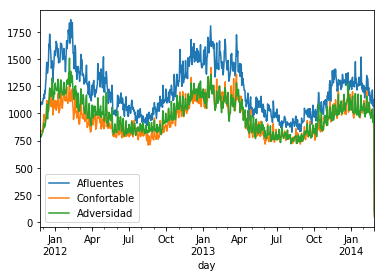

In [120]:
#Visualización de los datos segun Acorn
df.plot()

In [121]:
#Dataset usado para la prueba
df.head()

,Afluentes,Confortable,Adversidad
day,,,
2011-11-23,1021.759001,794.949,777.872
2011-11-24,1037.756001,820.013,785.898
2011-11-25,1067.520001,828.463,788.827
2011-11-26,1098.287001,839.799,782.273
2011-11-27,1105.152001,837.558,801.556


In [122]:
df.tail()

,Afluentes,Confortable,Adversidad
day,,,
2014-02-24,1099.269999,922.704,939.615000
2014-02-25,1067.055001,926.006,915.180001
2014-02-26,1117.657999,919.748,941.084999
2014-02-27,1128.752001,913.275,979.032000
2014-02-28,57.106000,42.321,95.483000


In [123]:
len(df) 

829

In [0]:
#LSTM Multiple Parallel Series


In [0]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df)

In [126]:
dataset[0:5]

array([[0.5340193 , 0.54538893, 0.48283448],
       [0.54287503, 0.56355146, 0.48851339],
       [0.55935199, 0.56967472, 0.49058585],
       [0.5763842 , 0.57788931, 0.48594847],
       [0.58018458, 0.57626538, 0.49959244]])

In [127]:
''' Dividiendo el dataset en training y test '''
#dataset = df.values
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

580 249


In [0]:
# split a multivariate sequence into samples
#Función para crear tramas de tiempo con look backs
def create_dataset(sequences, n_steps=1):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [0]:
''' Creando las tramas de tiempo con look backs'''
look_back = 8
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [130]:
trainX[0]

array([[0.5340193 , 0.54538893, 0.48283448],
       [0.54287503, 0.56355146, 0.48851339],
       [0.55935199, 0.56967472, 0.49058585],
       [0.5763842 , 0.57788931, 0.48594847],
       [0.58018458, 0.57626538, 0.49959244],
       [0.5675556 , 0.57567044, 0.49469539],
       [0.56893735, 0.5768393 , 0.51062975],
       [0.57274215, 0.5754516 , 0.51282957]])

In [131]:
trainX.shape

(572, 8, 3)

In [132]:
trainY[0]

array([0.58227603, 0.59352645, 0.5180047 ])

In [0]:
#''' Re-shaping los datos según los requerimientos del modelo  '''
#trainX = np.reshape(trainX, (trainX.shape[0], 8, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 8, testX.shape[1]))

W0709 16:29:32.718224 139773856483200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 16:29:32.764060 139773856483200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 16:29:32.774855 139773856483200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 16:29:33.053786 139773856483200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0709 16:29:33.311401 139773856483200 deprecation.py:323

Train on 572 samples, validate on 241 samples
Epoch 1/400
 - 4s - loss: 0.4544 - val_loss: 0.1129
Epoch 2/400
 - 0s - loss: 0.0872 - val_loss: 0.0458
Epoch 3/400
 - 0s - loss: 0.0617 - val_loss: 0.0605
Epoch 4/400
 - 0s - loss: 0.0619 - val_loss: 0.0511
Epoch 5/400
 - 0s - loss: 0.0461 - val_loss: 0.0406
Epoch 6/400
 - 0s - loss: 0.0481 - val_loss: 0.0332
Epoch 7/400
 - 0s - loss: 0.0440 - val_loss: 0.0306
Epoch 8/400
 - 0s - loss: 0.0432 - val_loss: 0.0300
Epoch 9/400
 - 0s - loss: 0.0433 - val_loss: 0.0303
Epoch 10/400
 - 0s - loss: 0.0430 - val_loss: 0.0309
Epoch 11/400
 - 0s - loss: 0.0423 - val_loss: 0.0315
Epoch 12/400
 - 0s - loss: 0.0427 - val_loss: 0.0318
Epoch 13/400
 - 0s - loss: 0.0424 - val_loss: 0.0325
Epoch 14/400
 - 0s - loss: 0.0421 - val_loss: 0.0331
Epoch 15/400
 - 0s - loss: 0.0422 - val_loss: 0.0324
Epoch 16/400
 - 0s - loss: 0.0421 - val_loss: 0.0329
Epoch 17/400
 - 0s - loss: 0.0415 - val_loss: 0.0320
Epoch 18/400
 - 0s - loss: 0.0415 - val_loss: 0.0328
Epoch 19/

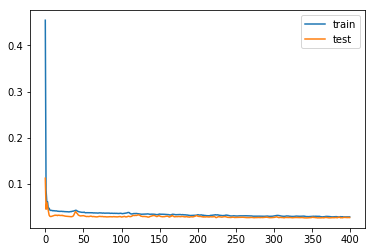

In [133]:
''' Ajuste de los datos en el modelo LSTM Deep Learning '''
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
#model.add(LSTM(units=30, return_sequences=True))
#model.add(LSTM(units=30))
model.add(Dense(3))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=400, batch_size=50, validation_data=(testX, testY), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
#Predicción del consumo una vez que el modelo está entrenado
yhat = model.predict(testX)

In [0]:
yhat1=yhat[:,2]

In [0]:
testY1=testY[:,2]

In [0]:
yhat.shape

(241, 3)

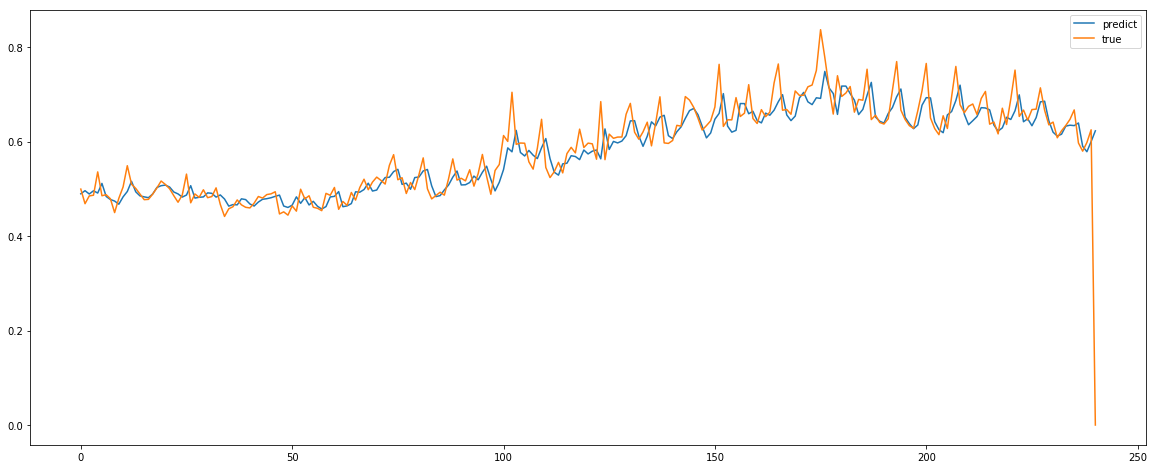

In [137]:
''' Plotting las 241 entradas de la parte del entrenamiento '''
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat1[0:241], label='predict')
pyplot.plot(testY1[0:241], label='true')
pyplot.legend()
pyplot.show()

In [138]:
print("Mean squared error: %.3f" % mean_squared_error(testY, yhat))

Mean squared error: 0.003


In [139]:
print("Root mean squared error: %.3f" % sqrt(mean_squared_error(testY, yhat)))

Root mean squared error: 0.053


In [140]:
from sklearn.metrics import mean_squared_error, r2_score
print('Variance : %.3f' % r2_score(testY, yhat))


Variance : 0.722


In [0]:

testPredict = scaler.inverse_transform(yhat)

In [0]:

testYnormal = scaler.inverse_transform(testY)

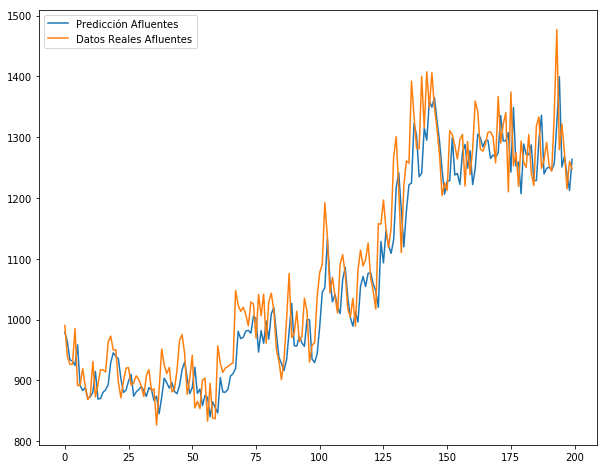

In [143]:
''' Plotting la predicción de los Afluentes  '''
pyplot.figure(figsize=(10,8))
pyplot.plot(testPredict[0:200,0], label='Predicción Afluentes')
pyplot.plot(testYnormal[0:200,0], label='Datos Reales Afluentes')
pyplot.legend()
pyplot.show()

In [153]:
print("Mean squared error: %.3f" % mean_squared_error(testYnormal, testPredict))

Mean squared error: 6449.118


In [147]:
print("Root mean squared error: %.3f" % sqrt(mean_squared_error(testYnormal, testPredict)))

Root mean squared error: 80.306


In [148]:
from sklearn.metrics import mean_squared_error, r2_score
print('Variance : %.3f' % r2_score(testYnormal, testPredict))

Variance : 0.722


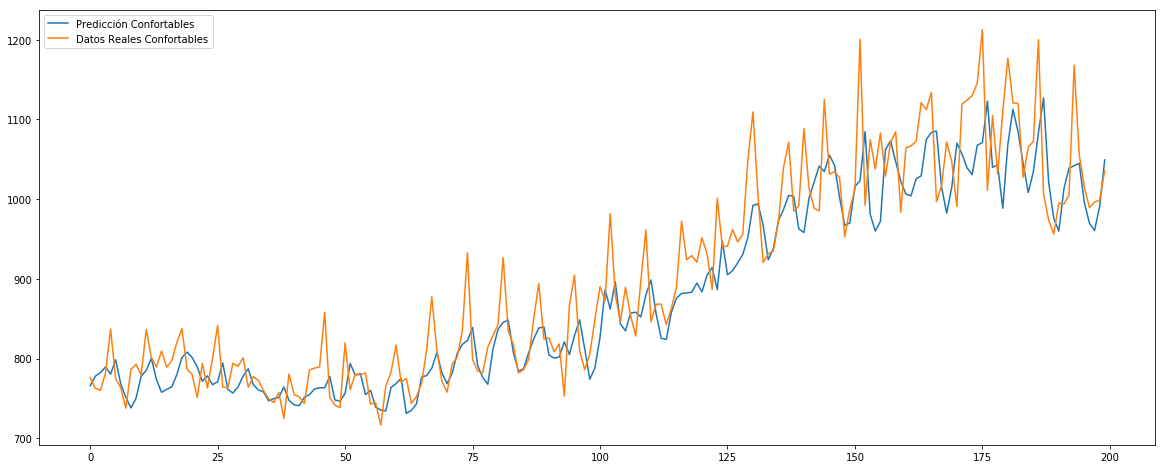

In [144]:
''' Plotting la predicción de los Confortables '''
pyplot.figure(figsize=(20,8))
pyplot.plot(testPredict[0:200,1], label='Predicción Confortables')
pyplot.plot(testYnormal[0:200,1], label='Datos Reales Confortables')
pyplot.legend()
pyplot.show()

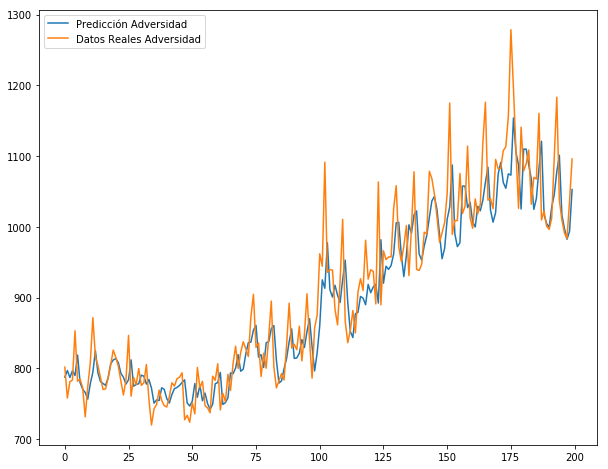

In [154]:
''' Plotting la predicción del Acorn Adversidad '''
pyplot.figure(figsize=(10,8))
pyplot.plot(testPredict[0:200,2], label='Predicción Adversidad')
pyplot.plot(testYnormal[0:200,2], label='Datos Reales Adversidad')
pyplot.legend()
pyplot.show()